<h1> Overlapping clusters - first working network </h1>
Date: 24th March 2023

Let's see if I go my data selection correct. 
I assume I might increase the size of my neural network as the input and output data gets bigger. I investigate a more complicated problem now.

In [1]:
# own skrips
import myfunctions as mf
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

In [2]:
rootfile = uproot.open('./stage4_clusters.root')
ipd = hf.InputData_2photon(rootfile)
ipd.form_cluster()
ipd.train_test_split()
ipd.prep_trainingsdata()
ipd.prep_verificationdata()

Initialized object
Start shaping clusters in a  (8, 8)  grid...
Shaping the clusters took  155.21915936470032 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [3]:
print(ipd.clusters_t.shape)
print(ipd.training.shape)

(524001, 64)
(524001, 6)


Seems like everything went well!!

In [4]:
ind_bad0 = np.where(ipd.num_fit == 0)
ind_bad1 = np.where(ipd.num_fit == 1)
ind_bad2 = np.where(ipd.num_fit == 2)
ind_bad3 = np.where(ipd.num_fit == 3)
ind_bad4 = np.where(ipd.num_fit == 4)
ind_bad5 = np.where(ipd.num_fit == 5)
print("number of 0 coral showers: ", len(ind_bad0[0]))
print("number of 1 coral showers: ", len(ind_bad1[0]))
print("number of 2 coral showers: ", len(ind_bad2[0]))
print("number of 3 coral showers: ", len(ind_bad3[0]))
print("number of 4 coral showers: ", len(ind_bad4[0]))
print("number of 5 coral showers: ", len(ind_bad5[0]))
print("Total amought of fits: ", len(ipd.num_fit))

number of 0 coral showers:  0
number of 1 coral showers:  175323
number of 2 coral showers:  475931
number of 3 coral showers:  3716
number of 4 coral showers:  31
number of 5 coral showers:  0
Total amought of fits:  655001


Wow! Only 71,96% (wrong dataset) of the coral fits have a correct number of showers. This will be interesting in the future.

<h2> The network </h2>

I might need to check if the mean and variance are still applicable... But finetuning later on.

I start with the same size of the network and will adjust it - if needed - later on.

In [5]:
model = keras.Sequential([layers.Input(shape=(64)),
                         layers.Normalization(mean=3.9, variance=16.2),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(6, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.01))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2

Notes:
- with settings as with 1 photons the loss is still around 600 after 20 epochs. I will increase the learning rate to $\alpha$ = 0.00005
- this didn't help much. I change the size of the network. I delete the first 64 layer but instead a total of 3  256 layers in the middle.
- this also doesn't help. I go back to the old architecture.
- I increase the learning rate to $\alpha = 0.0001$
- also no success. Set $\alpha = 0.001$
- Well, also no success. Let's try $\alpha = 0.01$
- I might need to conclude my data is wrong. Let's have a look.
- I found an potential error in the data. I didn't save all the hit cells! Changed this. Let's see. 
- Still not working. 

**Problem:** how to assign the frist 3 and last 3 entries? 
- Try: bigger $E$ is the first 3, the shower with lower energy the last 3.
- Alternativly: Use smaller $x$ for frist 3, bigger $x$ (the cluster more to the right) for the last three. 

In [6]:
a = time.time()
fit_hist = model.fit(ipd.clusters_t, ipd.training, batch_size=64, epochs=200, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/200
7369/7369 [==============================] - 7s 929us/step - loss: 144.7545 - val_loss: 125.1351
Epoch 2/200
7369/7369 [==============================] - 7s 913us/step - loss: 115.1620 - val_loss: 113.6799
Epoch 3/200
7369/7369 [==============================] - 7s 914us/step - loss: 108.5210 - val_loss: 107.4825
Epoch 4/200
7369/7369 [==============================] - 7s 937us/step - loss: 104.8526 - val_loss: 105.7144
Epoch 5/200
7369/7369 [==============================] - 7s 946us/step - loss: 102.4749 - val_loss: 101.6935
Epoch 6/200
7369/7369 [==============================] - 7s 943us/step - loss: 100.2525 - val_loss: 100.8252
Epoch 7/200
7369/7369 [==============================] - 7s 943us/step - loss: 98.9326 - val_loss: 99.3182
Epoch 8/200
7369/7369 [==============================] - 7s 914us/step - loss: 97.6341 - val_loss: 95.7075
Epoch 9/200
7369/7369 [==============================] - 7s 915us/step - loss: 96.6173 - val_loss: 97.8364
Epoch 10/200
7369/7369 [=

Epoch 77/200
7369/7369 [==============================] - 7s 945us/step - loss: 82.2689 - val_loss: 85.1330
Epoch 78/200
7369/7369 [==============================] - 7s 945us/step - loss: 82.1233 - val_loss: 90.5835
Epoch 79/200
7369/7369 [==============================] - 7s 945us/step - loss: 82.0676 - val_loss: 84.3646
Epoch 80/200
7369/7369 [==============================] - 7s 911us/step - loss: 81.9658 - val_loss: 85.3634
Epoch 81/200
7369/7369 [==============================] - 7s 916us/step - loss: 81.9890 - val_loss: 80.9655
Epoch 82/200
7369/7369 [==============================] - 7s 914us/step - loss: 82.0890 - val_loss: 82.1290
Epoch 83/200
7369/7369 [==============================] - 7s 914us/step - loss: 82.2190 - val_loss: 84.2102
Epoch 84/200
7369/7369 [==============================] - 7s 915us/step - loss: 81.9637 - val_loss: 83.0000
Epoch 85/200
7369/7369 [==============================] - 7s 915us/step - loss: 81.8162 - val_loss: 85.5073
Epoch 86/200
7369/7369 [====

7369/7369 [==============================] - 7s 917us/step - loss: 79.7169 - val_loss: 82.4478
Epoch 153/200
7369/7369 [==============================] - 7s 914us/step - loss: 79.6118 - val_loss: 82.3676
Epoch 154/200
7369/7369 [==============================] - 7s 916us/step - loss: 79.7837 - val_loss: 80.9609
Epoch 155/200
7369/7369 [==============================] - 7s 917us/step - loss: 79.4572 - val_loss: 83.0567
Epoch 156/200
7369/7369 [==============================] - 7s 914us/step - loss: 79.4816 - val_loss: 84.0130
Epoch 157/200
7369/7369 [==============================] - 7s 912us/step - loss: 79.6769 - val_loss: 81.4649
Epoch 158/200
7369/7369 [==============================] - 7s 914us/step - loss: 79.6504 - val_loss: 80.9519
Epoch 159/200
7369/7369 [==============================] - 7s 917us/step - loss: 79.6032 - val_loss: 81.0741
Epoch 160/200
7369/7369 [==============================] - 7s 917us/step - loss: 79.4099 - val_loss: 79.1580
Epoch 161/200
7369/7369 [========

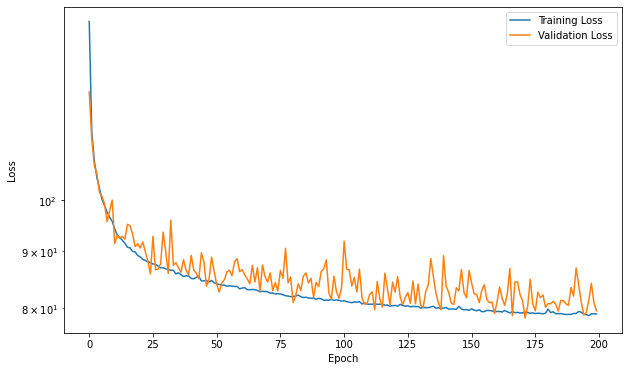

In [7]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

Yeay yeay yeay! Das sieht doch gar nicht schlecht aus! Es lernt etwas!! Learning rate ist jetzt natuerlich etwas hoch ahah aber passt schon fuer den Anfang :-)

<h2> check the data...</h2>

- Ok ind 7, 11, 16, 17, 18, 25, 30 are weird (old dataset). There is no second cluster?
- tried to fix this error... let's evaluate the new dataset!
- I think I fixed it - look at ind 9 - now there are also clusters that are completely seperate.
- ok, but ind 14 doesn't have two showers.. but one have E=0.38 GeV, maybe that's too low?
- yes it is, I implemented a threshold of 1GeV. 
- Apart fromt that data looks okay? 
- **Problem:** how to assign right energy value to one cluster? 

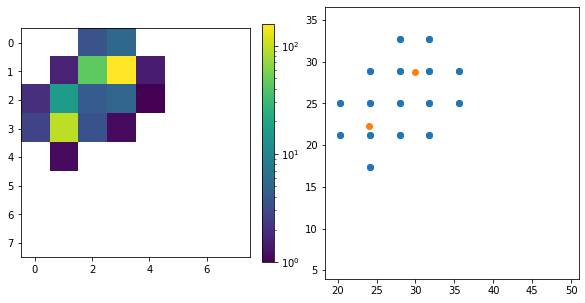

In [27]:
ind = 15 
plt.rcParams["figure.figsize"] = (10,5)

plt.subplot(1,2, 1)
cluster = ipd.clusterNxN[ind]
plt.imshow(cluster, norm=LogNorm())
im_ratio = cluster.shape[0]/cluster.shape[1]
plt.colorbar(fraction=0.047*im_ratio)

plt.subplot(1,2,2)
plt.scatter(ipd.xMC[ind], ipd.yMC[ind])
plt.scatter(ipd.x_truth[ind], ipd.y_truth[ind])
plt.xlim(ipd.coordinates[ind][0]-ipd.cellsize/2, ipd.coordinates[ind][0]+ipd.cellsize*8)
plt.ylim(ipd.coordinates[ind][1]-ipd.cellsize/2, ipd.coordinates[ind][1]+ipd.cellsize*8)
plt.show()

In [25]:
print(ipd.x_truth[ind], ipd.y_truth[ind], ipd.E_truth[ind])

[-67.96344453 -67.41177463] [-2.32300279 -8.00348803] [ 30.43842966 143.58776157]


<h2> Evalute neural network </h2>

Yeah the first draft worked! So now look at the performence.

In [10]:
output = model.predict(ipd.clusters_v)

/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/stage4/myfunctions.py:146: RuntimeWarning: divide by zero encountered in true_divide


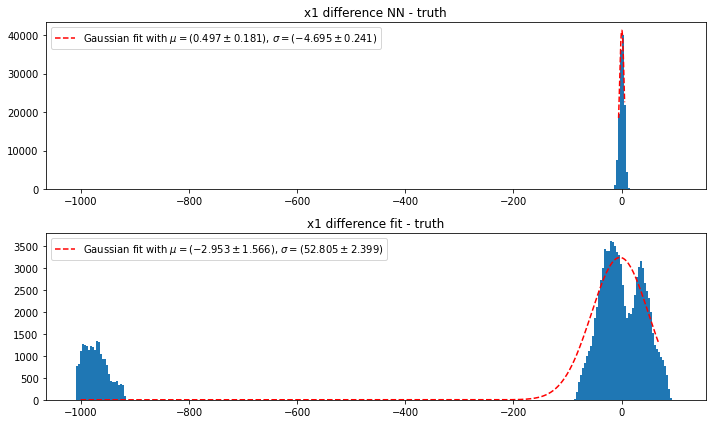

(array([ 4.96520576e-01, -4.69470249e+00,  4.84892102e+05]),
 array([1.80596091e-01, 2.40634293e-01, 1.99011702e+04]),
 array([-2.95296391e+00,  5.28051000e+01,  4.28760700e+05]),
 array([1.56600974e+00, 2.39887258e+00, 1.52805300e+04]))

In [15]:
mf.histo_output(output.T[0], ipd.veri_fit.T[0], ipd.veri_truth.T[0], name="x1", fit=True, range_x=(-1010,100))

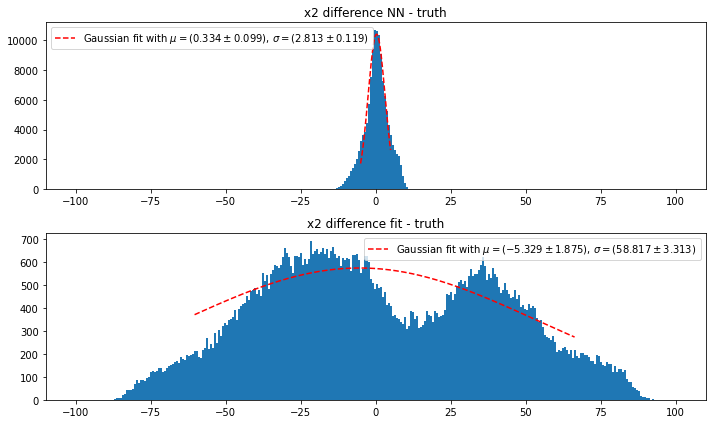

(array([3.33900741e-01, 2.81318488e+00, 7.33856414e+04]),
 array([9.90216417e-02, 1.19017545e-01, 2.56257006e+03]),
 array([-5.32861693e+00,  5.88171161e+01,  8.46527477e+04]),
 array([1.87523246e+00, 3.31275062e+00, 3.86763220e+03]))

In [21]:
mf.histo_output(output.T[3], ipd.veri_fit.T[3], ipd.veri_truth.T[3], name="x2", fit=True, range_x=(-100,100))

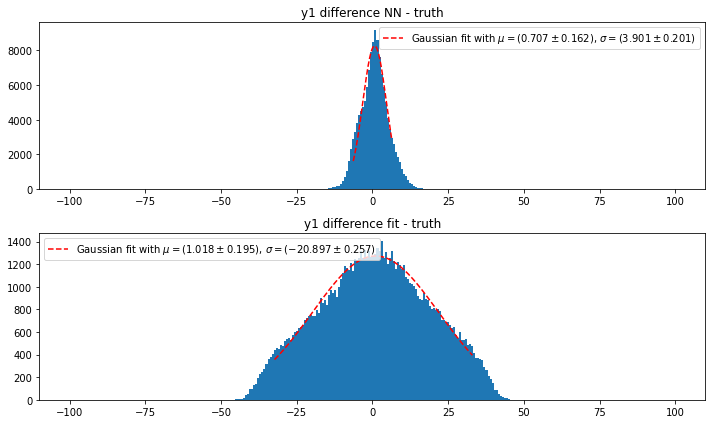

(array([7.07226584e-01, 3.90114558e+00, 8.07487058e+04]),
 array([1.62181118e-01, 2.01047918e-01, 3.40672454e+03]),
 array([ 1.01826224e+00, -2.08973081e+01,  6.66778211e+04]),
 array([1.95256423e-01, 2.57313154e-01, 6.62160036e+02]))

In [16]:
mf.histo_output(output.T[1], ipd.veri_fit.T[1], ipd.veri_truth.T[1], name="y1", range_x=(-100,100))

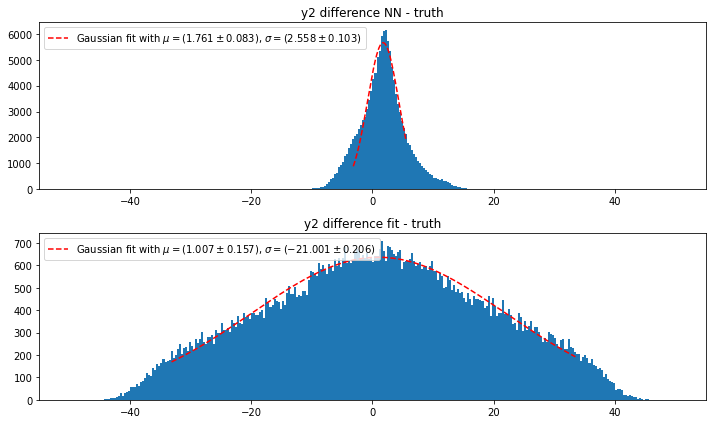

(array([1.76141164e+00, 2.55829581e+00, 3.62729735e+04]),
 array([8.34264434e-02, 1.02642149e-01, 1.19445426e+03]),
 array([ 1.00679672e+00, -2.10008551e+01,  3.34881072e+04]),
 array([1.56929744e-01, 2.05920244e-01, 2.65028103e+02]))

In [23]:
mf.histo_output(output.T[4], ipd.veri_fit.T[4], ipd.veri_truth.T[4], name="y2", range_x=(-50,50))

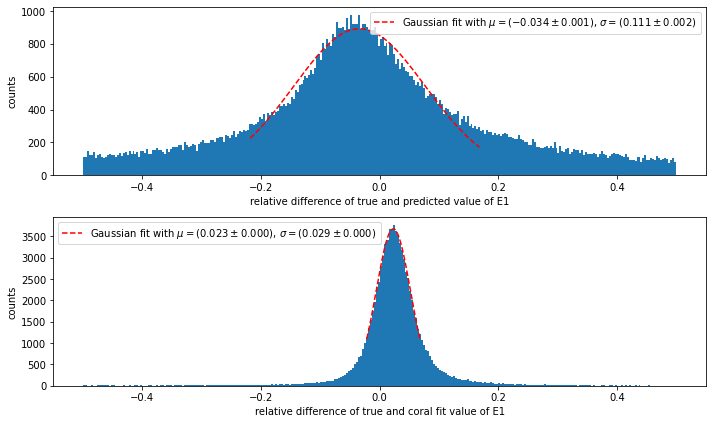

In [19]:
E_bad = mf.histo_output_relE(output.T[2], ipd.veri_fit.T[2], ipd.veri_truth.T[2], name="E1", range_x=(-0.5,0.5), fit=True)

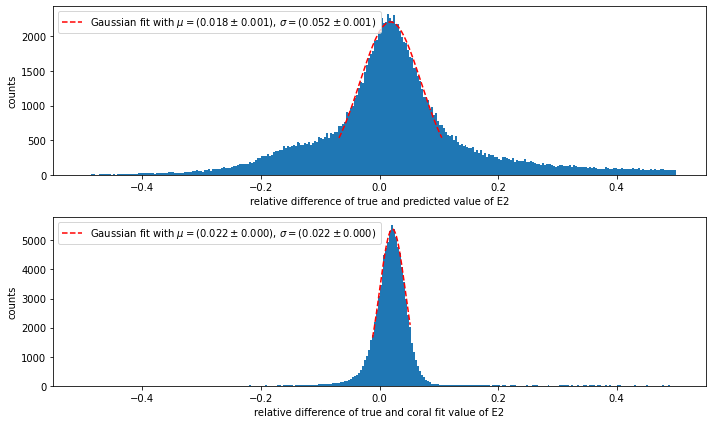

In [20]:
E_bad = mf.histo_output_relE(output.T[5], ipd.veri_fit.T[5], ipd.veri_truth.T[5], name="E2", range_x=(-0.5,0.5), fit=True)

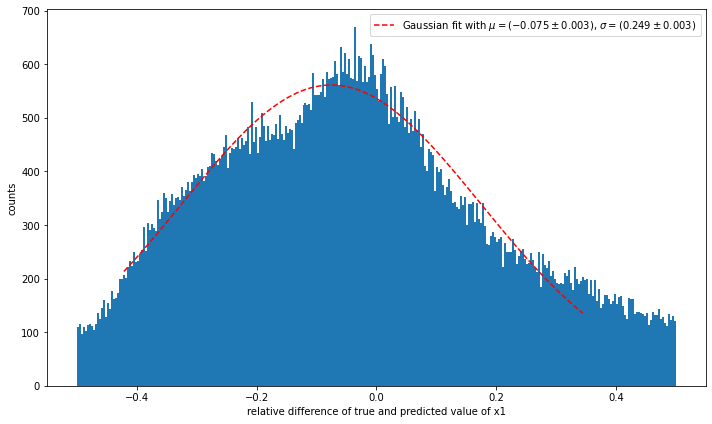

(array([ 3.63958585, 10.11199709, 15.78939435, ..., 10.43839299,
        23.03292955,  1.45892637]),
 array([33.34417731, 75.72348835,  6.52472693, ..., 39.41476725,
        24.37671499,  2.46579317]))

In [29]:
mf.histo_output_relxy(output.T[0], ipd.veri_truth.T[0], ipd.veri_truth.T[2], name='x1', range_x=(-0.5,0.5))

<h2> Conclusion </h2>

Well, the network learns something. But not reeeealy the right thing. But I still didn't increase the size of the network although the problem is a lot more difficult. There are many things to try out and change. So I have hope that the network will make it!

In [30]:
keras.models.save_model(model, 'stage4model_first_working')

INFO:tensorflow:Assets written to: stage4model_first_working/assets
